# Imports

In [1]:
%%capture

!pip install category_encoders
!pip install statsmodels
!pip install pystan==2.19.1.1
!pip install prophet

In [2]:
import warnings; 
warnings.simplefilter('ignore')

In [3]:
from evaluation import eval_clf, half_round, eval_regr, eval_all

In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

import category_encoders as ce
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier
import scipy as sp
import scipy.fftpack
# from fbprophet import Prophet
from prophet import Prophet
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler 

In [5]:
# df = pd.read_csv('data/mood.csv')
# df['time'] = pd.to_datetime(df['time'])
# df.head()

In [6]:
X_train = pd.read_csv('data/X_train.csv', index_col=0)
X_train_minmax_scaled = pd.read_csv('data/X_train_minmax_scaled.csv', index_col=0)
X_test = pd.read_csv('data/X_test.csv', index_col=0)
X_test_minmax_scaled = pd.read_csv('data/X_test_minmax_scaled.csv', index_col=0)
y_train = pd.read_csv('data/y_train.csv', index_col=0)
y_test = pd.read_csv('data/y_test.csv', index_col=0)

# Task 2

## Baselines

### Prevous mood as prediction

In [7]:
y_pred = X_test['mood']

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         0
         3.5       0.00      0.00      0.00         1
         5.0       0.40      0.40      0.40         5
         5.5       0.23      0.21      0.22        14
         6.0       0.33      0.32      0.32        44
         6.5       0.23      0.23      0.23        44
         7.0       0.57      0.58      0.58       157
         7.5       0.23      0.24      0.24        58
         8.0       0.31      0.30      0.31        56
         8.5       0.00      0.00      0.00         3
         9.0       0.00      0.00      0.00         3

    accuracy                           0.39       385
   macro avg       0.21      0.21      0.21       385
weighted avg       0.39      0.39      0.39       385



{'Baseline same as previous day': {'f1': 0.39,
  'rounded_rmse': 0.74,
  'rmse': 0.73}}

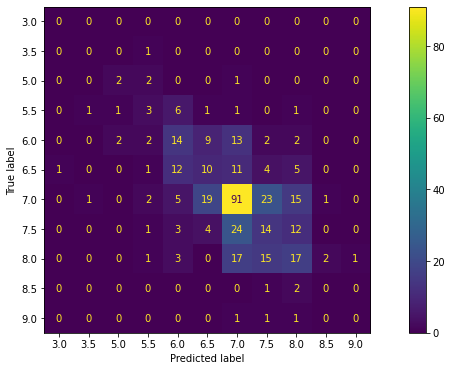

In [8]:
eval_all(y_test, y_pred, 'Baseline same as previous day')

### Average between prevous mood and one before as prediction

In [9]:
y_pred = (X_test['mood'] + X_test['prev_mood'])/2

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.5       0.00      0.00      0.00         0
         5.0       0.14      0.20      0.17         5
         5.5       0.38      0.21      0.27        14
         6.0       0.36      0.27      0.31        44
         6.5       0.23      0.32      0.27        44
         7.0       0.61      0.57      0.59       157
         7.5       0.24      0.38      0.29        58
         8.0       0.47      0.27      0.34        56
         8.5       0.00      0.00      0.00         3
         9.0       0.00      0.00      0.00         3

    accuracy                           0.41       385
   macro avg       0.22      0.20      0.20       385
weighted avg       0.44      0.41      0.41       385



{'Average between prevous mood and one before': {'f1': 0.41,
  'rounded_rmse': 0.69,
  'rmse': 0.67}}

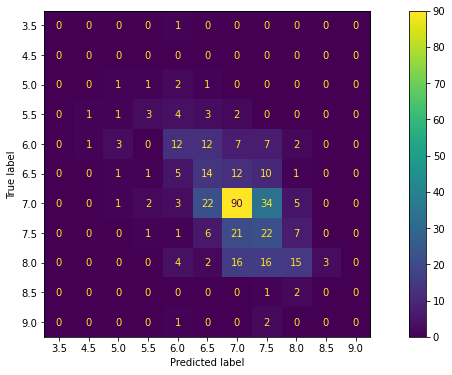

In [10]:
eval_all(y_test, y_pred, 'Average between prevous mood and one before')

### Average train mood as a baseline

In [11]:
avg_mood = np.mean(y_train)

y_pred = pd.DataFrame([avg_mood] * len(y_test))

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         5
         5.5       0.00      0.00      0.00        14
         6.0       0.00      0.00      0.00        44
         6.5       0.00      0.00      0.00        44
         7.0       0.41      1.00      0.58       157
         7.5       0.00      0.00      0.00        58
         8.0       0.00      0.00      0.00        56
         8.5       0.00      0.00      0.00         3
         9.0       0.00      0.00      0.00         3

    accuracy                           0.41       385
   macro avg       0.04      0.10      0.06       385
weighted avg       0.17      0.41      0.24       385



{'Average baseline': {'f1': 0.41, 'rounded_rmse': 0.74, 'rmse': 0.72}}

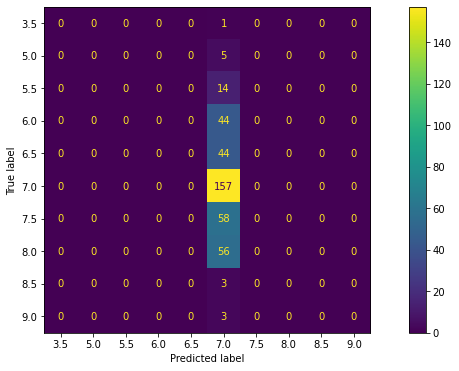

In [12]:
eval_all(y_test, y_pred, 'Average baseline')

## Feature Engineered model (8 points)

### SGD Regression

In [13]:
# Grid search hyperparams
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression 
model = linear_model.SGDRegressor()

param_grid = {
    'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05],
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
}

clf = GridSearchCV(model, param_grid, refit=True)
clf.fit(X_train_minmax_scaled, y_train)
print("Best score: " + str(clf.best_score_))
print("Best params: " + str(clf.best_params_))
model = clf.best_estimator_

Best score: 0.128413717537856
Best params: {'alpha': 0.01, 'learning_rate': 'constant', 'loss': 'epsilon_insensitive', 'penalty': 'l1'}


              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         1
         3.5       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         3
         4.5       0.00      0.00      0.00         3
         5.0       0.00      0.00      0.00         9
         5.5       0.00      0.00      0.00        13
         6.0       0.14      0.02      0.04        95
         6.5       0.27      0.38      0.32       129
         7.0       0.44      0.72      0.55       321
         7.5       0.30      0.25      0.27       146
         8.0       0.30      0.03      0.05       117
         8.5       0.00      0.00      0.00        14
         9.0       0.00      0.00      0.00         2
         9.5       0.00      0.00      0.00         1

    accuracy                           0.38       856
   macro avg       0.10      0.10      0.09       856
weighted avg       0.31      0.38      0.31       856



{'SGD Regression TRAIN': {'f1': 0.38, 'rounded_rmse': 0.65, 'rmse': 0.63}}

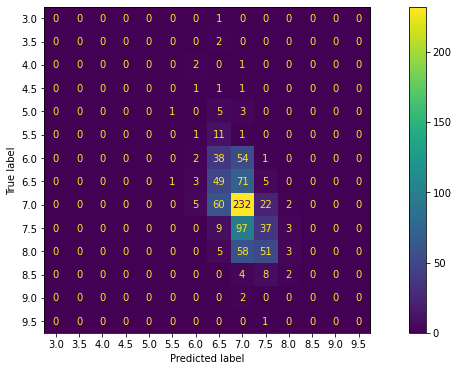

In [14]:
y_pred = pd.DataFrame(model.predict(X_train_minmax_scaled))
eval_all(y_train, y_pred, 'SGD Regression TRAIN')

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         5
         5.5       0.50      0.07      0.12        14
         6.0       0.33      0.07      0.11        44
         6.5       0.23      0.41      0.30        44
         7.0       0.52      0.80      0.63       157
         7.5       0.29      0.24      0.26        58
         8.0       0.60      0.05      0.10        56
         8.5       0.00      0.00      0.00         3
         9.0       0.00      0.00      0.00         3

    accuracy                           0.43       385
   macro avg       0.25      0.16      0.15       385
weighted avg       0.43      0.43      0.36       385



{'SGD Regression TEST': {'f1': 0.43, 'rounded_rmse': 0.62, 'rmse': 0.6}}

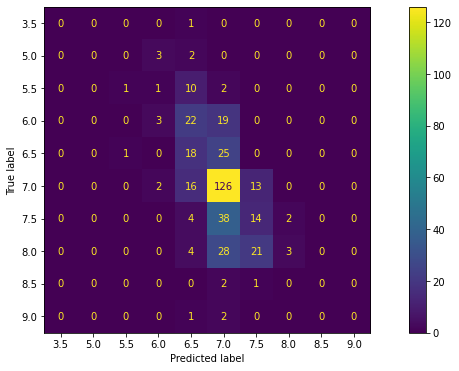

In [15]:
y_pred = pd.DataFrame(model.predict(X_test_minmax_scaled))
eval_all(y_test, y_pred, 'SGD Regression TEST')

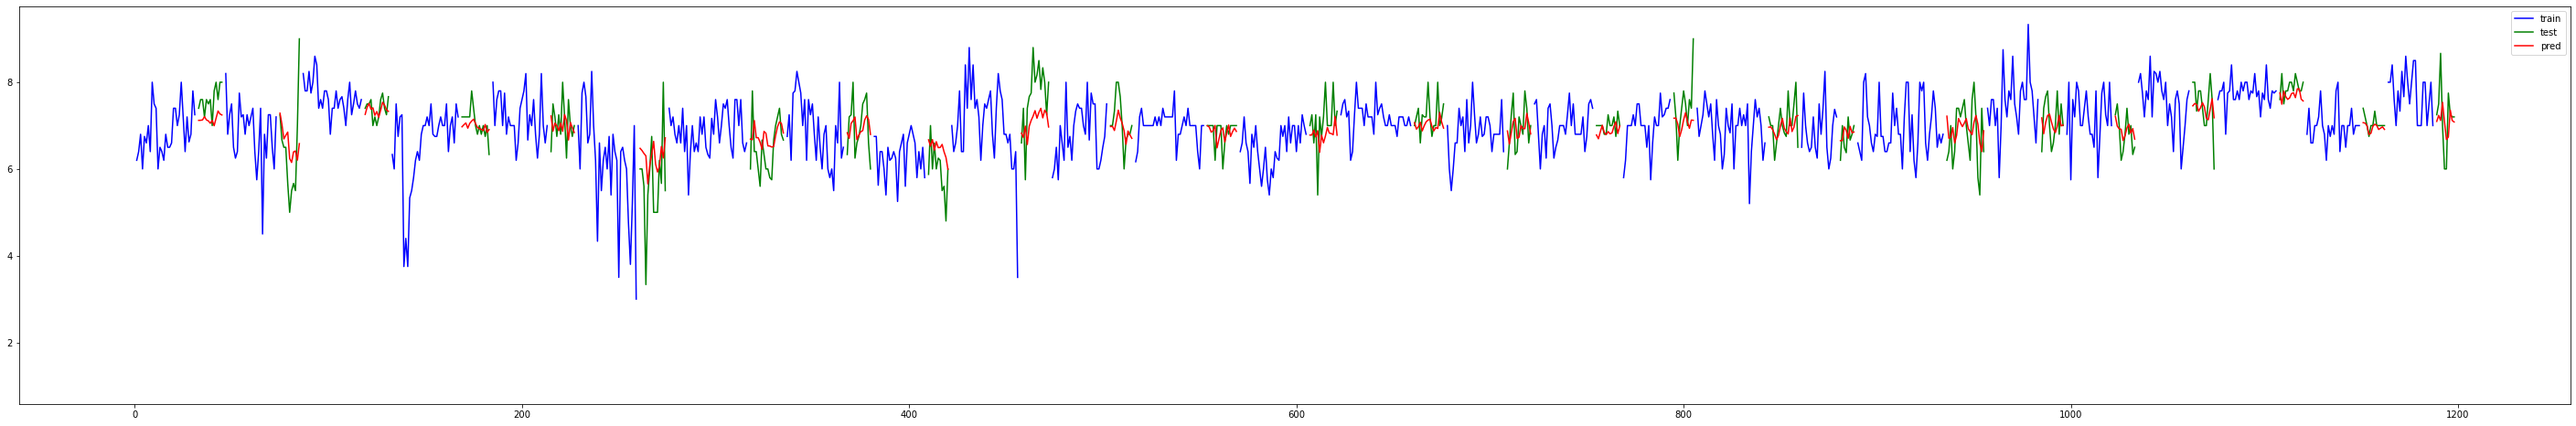

In [16]:
current_series_y = []
current_series_index = []
fig,ax = plt.subplots(figsize=(50,8))

i_prev = y_train.reset_index().iloc[0,:]['index']
for _,row in y_train.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='b')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row['0'])
        current_series_index.append(row['index'])
    i_prev = row['index']

current_series_y = []
current_series_index = []
i_prev = y_test.reset_index().iloc[0,:]['index']
for _,row in y_test.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='g')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row['0'])
        current_series_index.append(row['index'])
    i_prev = row['index']

current_series_y = []
current_series_index = []
y_pred_rescaled = pd.concat([pd.DataFrame(y_test.index, columns=['index']), y_pred], axis=1).set_index('index')
i_prev = y_pred_rescaled.reset_index().iloc[0,:]['index']
for _,row in y_pred_rescaled.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='r')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row[0])
        current_series_index.append(row['index'])
    i_prev = row['index']

l_train, = plt.plot([1], c='b')
l_test, = plt.plot([1], c='g')
l_pred, = plt.plot([1], c='r')



plt.legend([l_train, l_test, l_pred],['train', 'test', 'pred']);




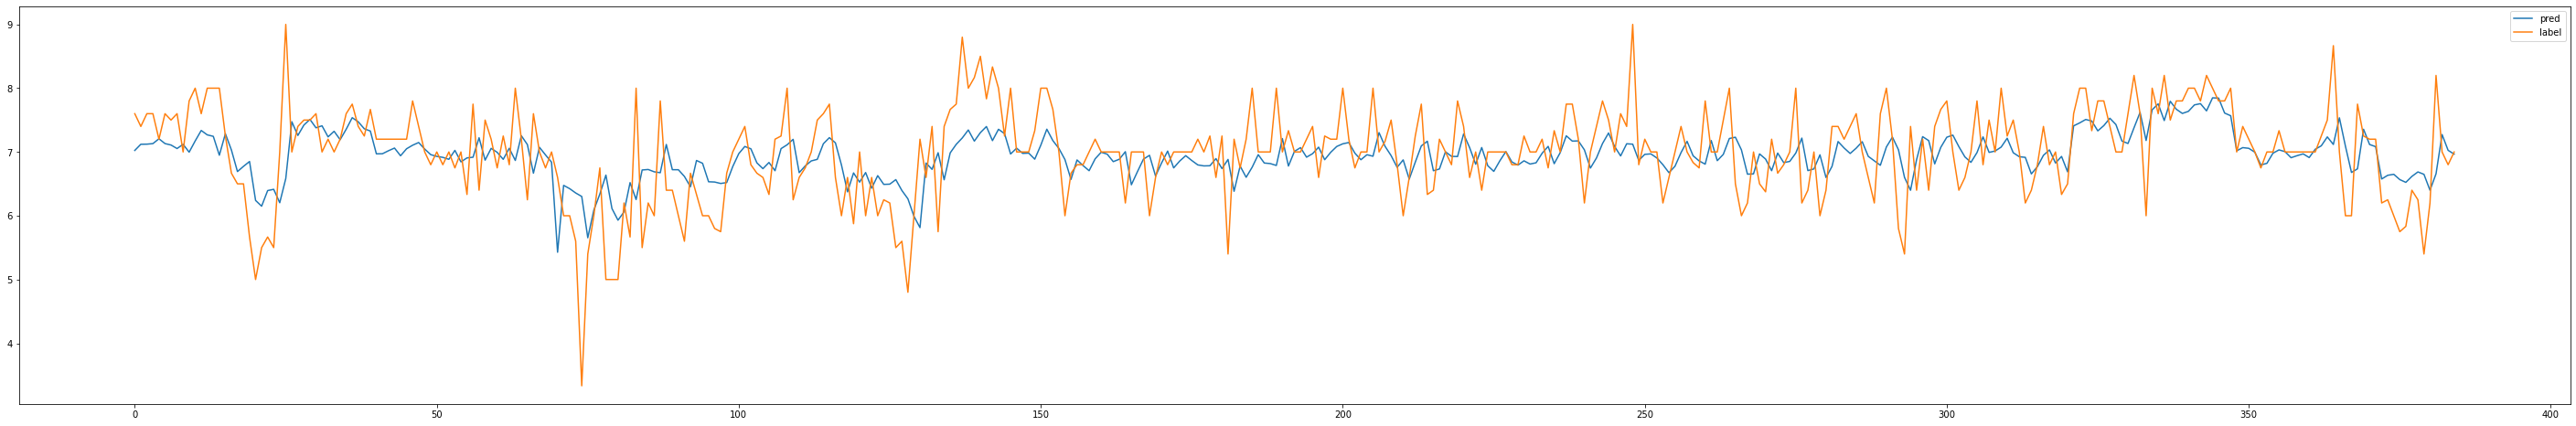

In [17]:
fig,ax = plt.subplots(figsize=(50,8))
ax.plot(list(y_pred[0]), label='pred')
ax.plot(list(y_test['0']), label='label')
ax.legend()

In [18]:
# # align index of test_pred with index of y_test
# test_pred = pd.concat([pd.DataFrame(y_test.index, columns=['index']), test_pred], axis=1).set_index('index')

# for idx in X_train.iloc[:,1:28].columns:
#     fig,ax = plt.subplots(figsize=(16,4))
#     ax.plot(y_train.loc[X_train[X_train[idx] == 1].index], label='train', c='b')
#     ax.plot(y_test.loc[X_test[X_test[idx] == 1].index], label='test', c='g')
#     ax.plot(test_pred.loc[X_test[X_test[idx] == 1].index], label='pred', c='r')
#     plt.legend()
#     plt.title(idx)

In [19]:
feature_importance = {}
feature_importance['feature'] = X_test_minmax_scaled.columns
feature_importance['importance'] = model.coef_
feature_importance['abs_importance'] = abs(feature_importance['importance'])
feature_importance = pd.DataFrame(feature_importance)
feature_importance.sort_values('abs_importance', ascending=False).head(25)

,feature,importance,abs_importance
27,mood,1.812100,1.812100
23,id_AS14.30,0.457600,0.457600
51,last_active,0.372866,0.372866
2,id_AS14.03,0.307600,0.307600
55,prev_mood,0.282395,0.282395
22,id_AS14.29,0.247600,0.247600
5,id_AS14.07,-0.217600,0.217600
63,dayofweek,0.200933,0.200933
54,last_active_change,0.175765,0.175765
8,id_AS14.12,-0.167600,0.167600


### DecisionTreeClassifier

In [20]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train_minmax_scaled, half_round(y_train)*10)

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         1
         3.5       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         3
         4.5       0.00      0.00      0.00         3
         5.0       0.00      0.00      0.00         9
         5.5       0.00      0.00      0.00        13
         6.0       0.80      0.08      0.15        95
         6.5       0.45      0.12      0.19       129
         7.0       0.43      0.91      0.59       321
         7.5       0.36      0.27      0.31       146
         8.0       0.83      0.16      0.27       117
         8.5       0.00      0.00      0.00        14
         9.0       0.00      0.00      0.00         2
         9.5       0.00      0.00      0.00         1

    accuracy                           0.44       856
   macro avg       0.20      0.11      0.11       856
weighted avg       0.49      0.44      0.35       856

probably, already rounded

{'DecisionTreeClassifier TRAIN': {'f1': 0.44,
  'rounded_rmse': 0.71,
  'rmse': 0.71}}

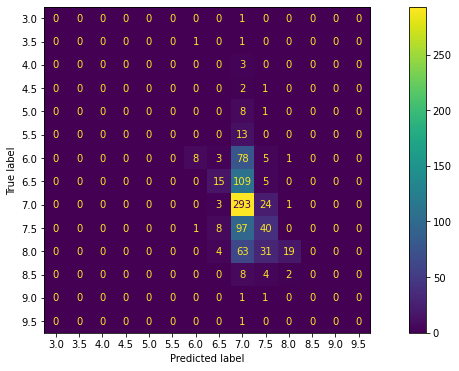

In [21]:
y_pred = pd.DataFrame(clf.predict(X_train_minmax_scaled))
eval_all(half_round(y_train), y_pred/10, 'DecisionTreeClassifier TRAIN')

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         5
         5.5       0.00      0.00      0.00        14
         6.0       1.00      0.02      0.04        44
         6.5       0.16      0.07      0.10        44
         7.0       0.44      0.87      0.58       157
         7.5       0.31      0.19      0.23        58
         8.0       0.44      0.12      0.19        56
         8.5       0.00      0.00      0.00         3
         9.0       0.00      0.00      0.00         3

    accuracy                           0.41       385
   macro avg       0.23      0.13      0.12       385
weighted avg       0.42      0.41      0.32       385

probably, already rounded values were passed


{'DecisionTreeClassifier TEST': {'f1': 0.41,
  'rounded_rmse': 0.72,
  'rmse': 0.72}}

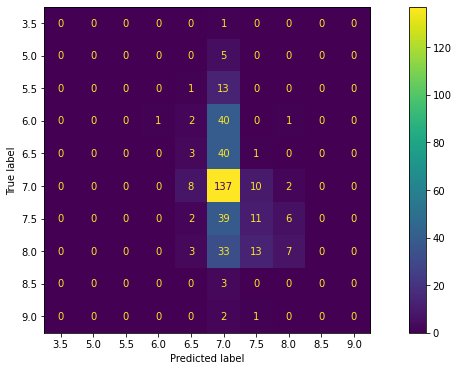

In [22]:
y_pred = pd.DataFrame(clf.predict(X_test_minmax_scaled))
eval_all(half_round(y_test), y_pred/10, 'DecisionTreeClassifier TEST')

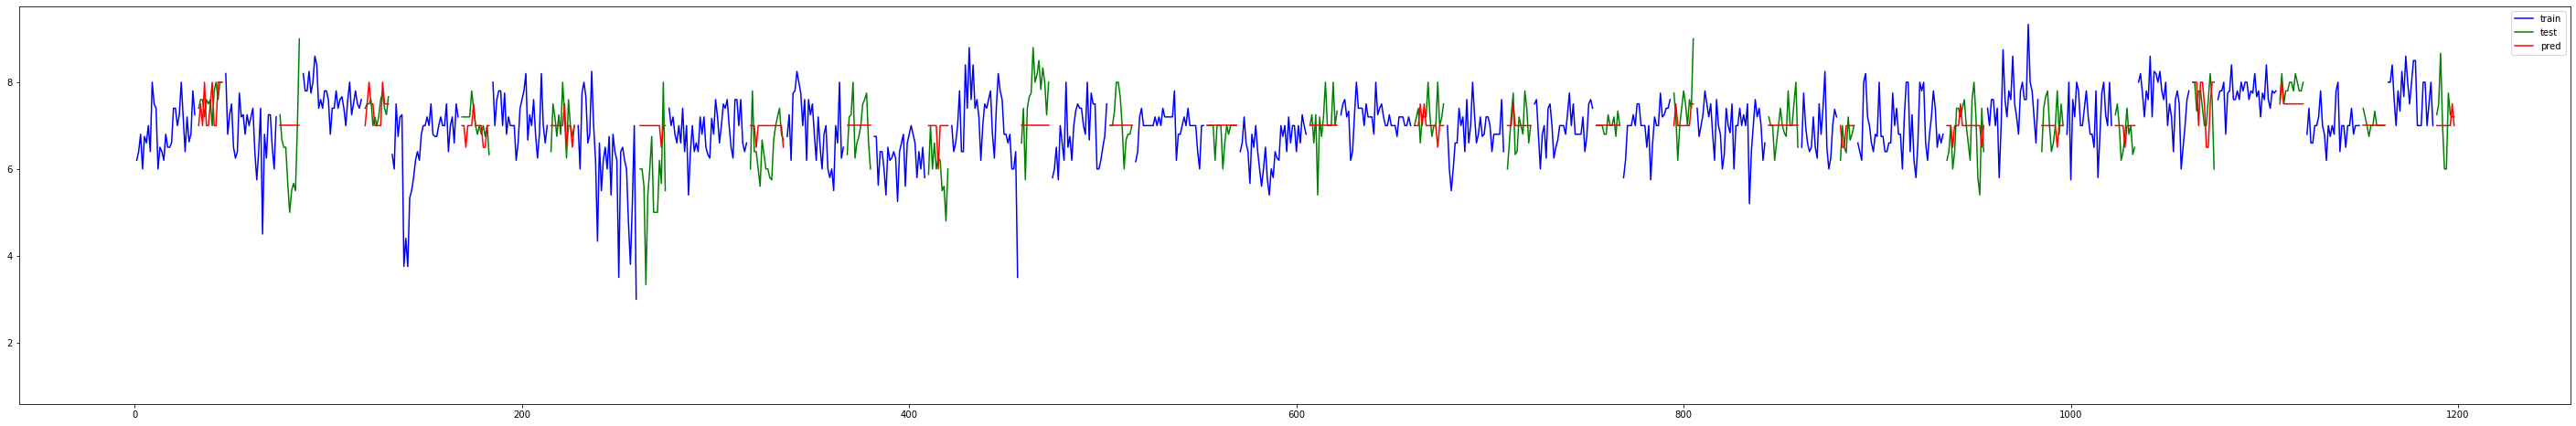

In [23]:
current_series_y = []
current_series_index = []
fig,ax = plt.subplots(figsize=(50,8))

i_prev = y_train.reset_index().iloc[0,:]['index']
for _,row in y_train.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='b')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row['0'])
        current_series_index.append(row['index'])
    i_prev = row['index']

current_series_y = []
current_series_index = []
i_prev = y_test.reset_index().iloc[0,:]['index']
for _,row in y_test.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='g')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row['0'])
        current_series_index.append(row['index'])
    i_prev = row['index']

current_series_y = []
current_series_index = []
y_pred_rescaled = pd.concat([pd.DataFrame(y_test.index, columns=['index']), y_pred], axis=1).set_index('index')/10
i_prev = y_pred_rescaled.reset_index().iloc[0,:]['index']
for _,row in y_pred_rescaled.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='r')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row[0])
        current_series_index.append(row['index'])
    i_prev = row['index']

l_train, = plt.plot([1], c='b')
l_test, = plt.plot([1], c='g')
l_pred, = plt.plot([1], c='r')



plt.legend([l_train, l_test, l_pred],['train', 'test', 'pred']);




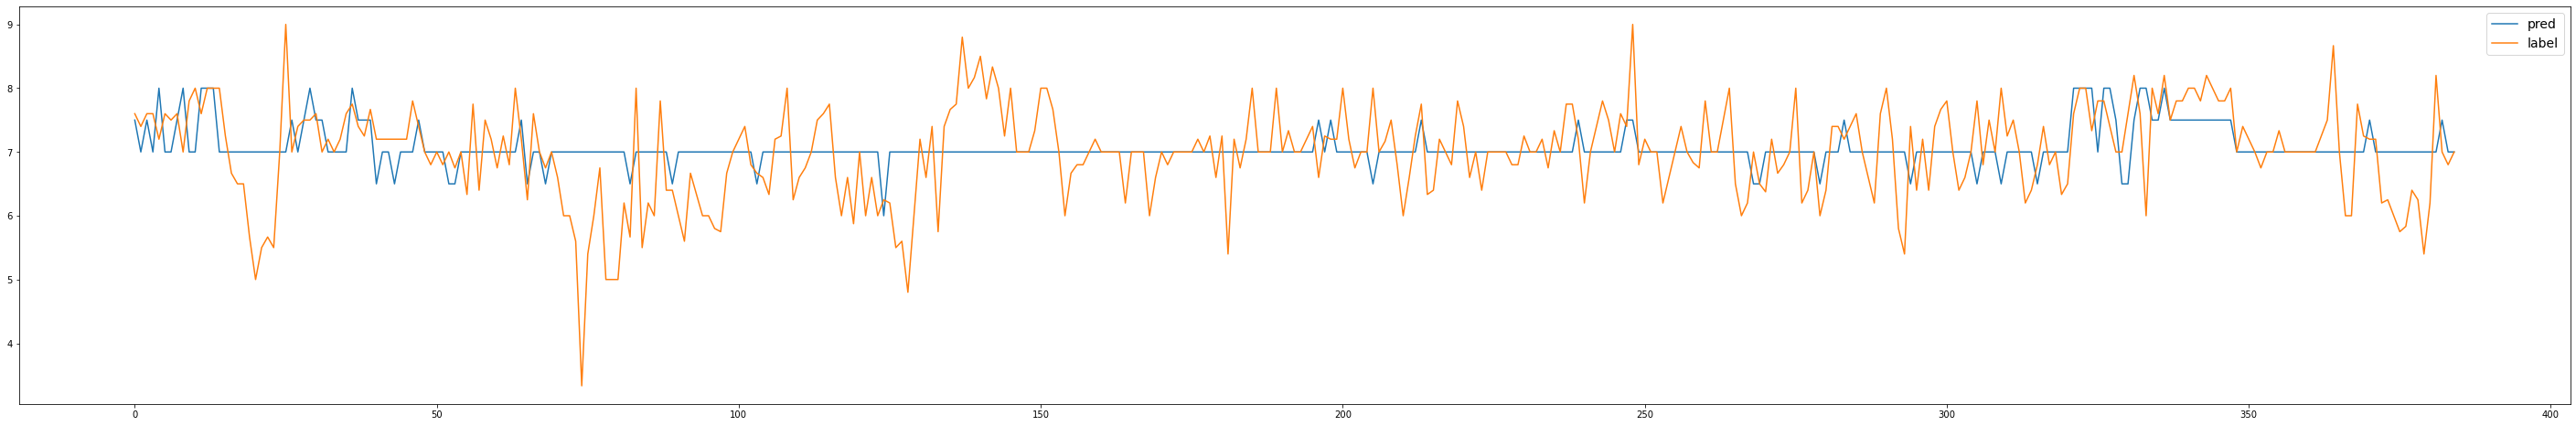

In [24]:
fig,ax = plt.subplots(figsize=(50,8))
ax.plot(y_pred/10, label='pred')
ax.plot(y_test.values, label='label')
ax.legend(fontsize=14)

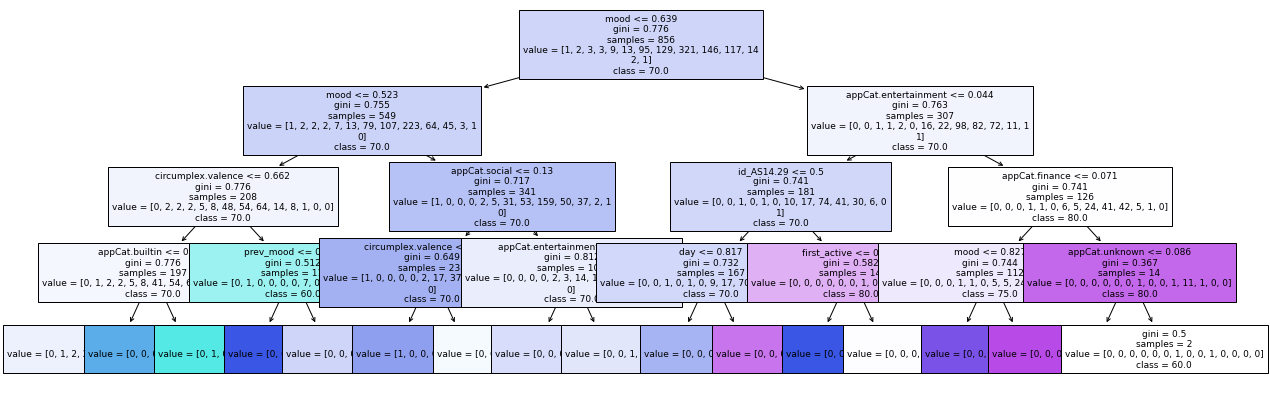

In [25]:
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1,
                        ncols=1,
                        figsize=(20, 7))

from sklearn import tree
tree.plot_tree(clf, 
               feature_names=X_test.columns, 
               class_names=[str(c) for c in clf.classes_],
            filled=True,
            max_depth=4,
            fontsize=9,
               );

### RandomForestClassifier

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
# features = ['mood',
#        'circumplex.arousal', 'circumplex.valence', 'activity',
#        'appCat.builtin', 'appCat.communication', 'appCat.entertainment',
#        'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other',
#        'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities',
#        'appCat.weather', 'call', 'screen', 'sms', 'asleep', 'active',
#        'missing_hour', 'mood_change', 'mood_prev1', 'day_num',
#        'sin(1,freq=W-SUN)', 'cos(1,freq=W-SUN)', 'sin(2,freq=W-SUN)',
#        'cos(2,freq=W-SUN)', 'sin(3,freq=W-SUN)', 'cos(3,freq=W-SUN)']

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         1
         3.5       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         3
         4.5       0.00      0.00      0.00         3
         5.0       0.00      0.00      0.00         9
         5.5       0.00      0.00      0.00        13
         6.0       0.00      0.00      0.00        95
         6.5       1.00      0.03      0.06       129
         7.0       0.40      0.99      0.57       321
         7.5       0.83      0.10      0.18       146
         8.0       0.70      0.26      0.37       117
         8.5       0.00      0.00      0.00        14
         9.0       0.00      0.00      0.00         2
         9.5       0.00      0.00      0.00         1

    accuracy                           0.43       856
   macro avg       0.21      0.10      0.09       856
weighted avg       0.54      0.43      0.31       856

probably, already rounded

{'RandomForestClassifier TRAIN': {'f1': 0.43,
  'rounded_rmse': 0.71,
  'rmse': 0.71}}

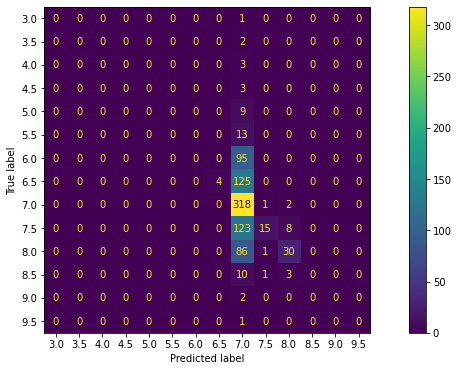

In [28]:
clf = RandomForestClassifier(max_depth=4)
clf = clf.fit(X_train_minmax_scaled, half_round(y_train)*10)


y_pred = pd.DataFrame(clf.predict(X_train_minmax_scaled))
eval_all(half_round(y_train), y_pred/10, 'RandomForestClassifier TRAIN')

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         5
         5.5       0.00      0.00      0.00        14
         6.0       0.00      0.00      0.00        44
         6.5       0.00      0.00      0.00        44
         7.0       0.42      0.99      0.59       157
         7.5       0.50      0.03      0.06        58
         8.0       0.93      0.23      0.37        56
         8.5       0.00      0.00      0.00         3
         9.0       0.00      0.00      0.00         3

    accuracy                           0.44       385
   macro avg       0.19      0.13      0.10       385
weighted avg       0.38      0.44      0.30       385

probably, already rounded values were passed


{'RandomForestClassifier TEST': {'f1': 0.44,
  'rounded_rmse': 0.71,
  'rmse': 0.71}}

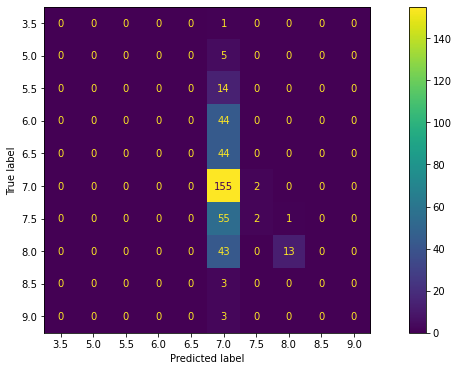

In [29]:
y_pred = pd.DataFrame(clf.predict(X_test_minmax_scaled))
eval_all(half_round(y_test), y_pred/10, 'RandomForestClassifier TEST')

In [30]:
for el in sorted(zip(X_train_minmax_scaled.columns, clf.feature_importances_), key=lambda x: x[1], 
                 reverse=True):
    print(el)

('mood', 0.11768744987524227)
('prev_mood', 0.06832911343769194)
('appCat.other', 0.051234213306413465)
('appCat.social', 0.0510386023889826)
('circumplex.valence', 0.044539879553596694)
('screen', 0.04400638074519219)
('appCat.builtin', 0.039671014348289346)
('appCat.entertainment', 0.03922034485868694)
('id_AS14.30', 0.035529970189559425)
('id_AS14.03', 0.03454141348756217)
('appCat.communication', 0.026723406540271097)
('appCat.office', 0.025606933561151554)
('day', 0.02377961823297665)
('circumplex.arousal', 0.02267972818070181)
('dayofyear', 0.022066212372126377)
('appCat.finance', 0.021254354393956114)
('id_AS14.15', 0.017851925086050997)
('appCat.travel', 0.016366581422882928)
('activity', 0.016160580147639412)
('first_active', 0.015618819292950815)
('last_active', 0.015269498169966214)
('appCat.unknown', 0.014424413073450578)
('missing_hour', 0.014266492445514124)
('mood_change', 0.01234550829382566)
('appCat.weather', 0.011989316621455562)
('id_AS14.17', 0.01178369619576254)
(

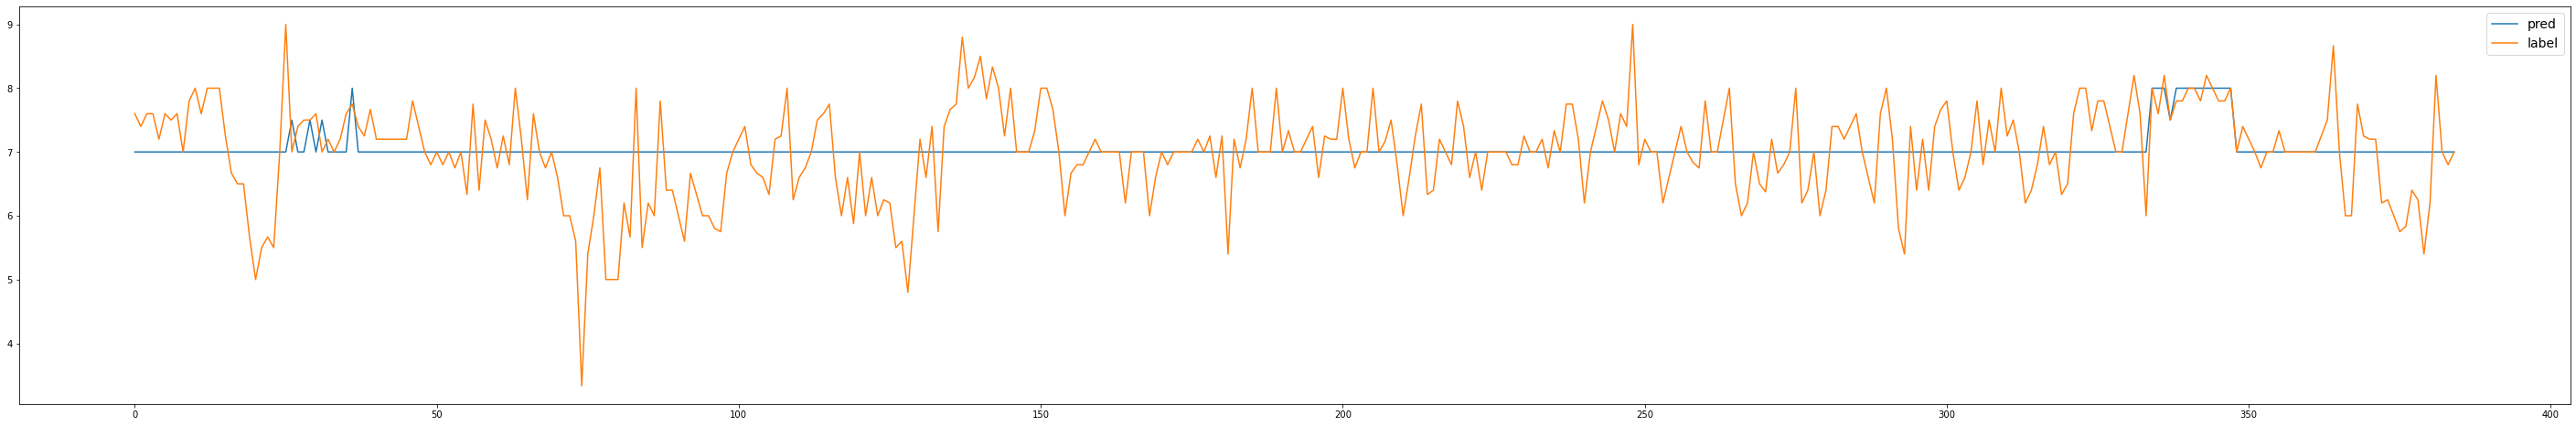

In [31]:
fig,ax = plt.subplots(figsize=(50,8))
ax.plot(y_pred/10, label='pred')
ax.plot(y_test.values, label='label')
ax.legend(fontsize=14)

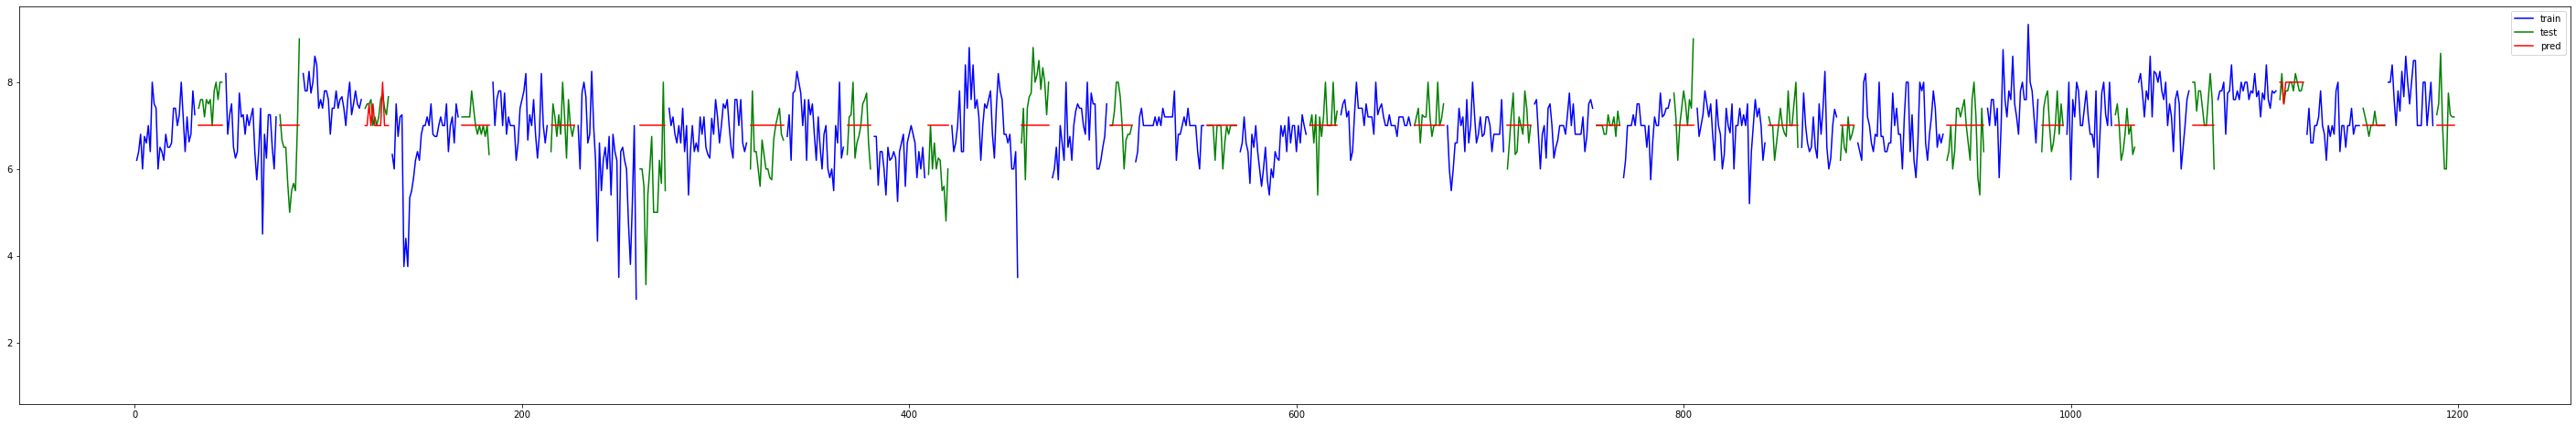

In [32]:
current_series_y = []
current_series_index = []
fig,ax = plt.subplots(figsize=(50,8))

i_prev = y_train.reset_index().iloc[0,:]['index']
for _,row in y_train.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='b')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row['0'])
        current_series_index.append(row['index'])
    i_prev = row['index']

current_series_y = []
current_series_index = []
i_prev = y_test.reset_index().iloc[0,:]['index']
for _,row in y_test.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='g')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row['0'])
        current_series_index.append(row['index'])
    i_prev = row['index']

current_series_y = []
current_series_index = []
y_pred_rescaled = pd.concat([pd.DataFrame(y_test.index, columns=['index']), y_pred], axis=1).set_index('index')/10
i_prev = y_pred_rescaled.reset_index().iloc[0,:]['index']
for _,row in y_pred_rescaled.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='r')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row[0])
        current_series_index.append(row['index'])
    i_prev = row['index']

l_train, = plt.plot([1], c='b')
l_test, = plt.plot([1], c='g')
l_pred, = plt.plot([1], c='r')



plt.legend([l_train, l_test, l_pred],['train', 'test', 'pred']);


### TPOT

In [33]:
%%capture
!pip install tpot

In [39]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, 
                      random_state=42,
                      n_jobs=-1,
                    #   config_dict='TPOT NN'
                      )
tpot.fit(X_train_minmax_scaled, half_round(y_train).astype(str))

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.3750033999728002

Generation 2 - Current best internal CV score: 0.376172990616075

Generation 3 - Current best internal CV score: 0.376172990616075

Generation 4 - Current best internal CV score: 0.37734258125934994

Generation 5 - Current best internal CV score: 0.37734258125934994

Best pipeline: ExtraTreesClassifier(PCA(GradientBoostingClassifier(input_matrix, learning_rate=1.0, max_depth=5, max_features=0.25, min_samples_leaf=12, min_samples_split=4, n_estimators=100, subsample=0.6000000000000001), iterated_power=1, svd_solver=randomized), bootstrap=True, criterion=entropy, max_features=0.8, min_samples_leaf=19, min_samples_split=5, n_estimators=100)


ValueError: Classification metrics can't handle a mix of continuous and multiclass targets

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         5
         5.5       0.00      0.00      0.00        14
         6.0       0.00      0.00      0.00        44
         6.5       0.00      0.00      0.00        44
         7.0       0.42      0.96      0.59       157
         7.5       0.58      0.12      0.20        58
         8.0       0.81      0.23      0.36        56
         8.5       0.00      0.00      0.00         3
         9.0       0.00      0.00      0.00         3

    accuracy                           0.44       385
   macro avg       0.18      0.13      0.11       385
weighted avg       0.38      0.44      0.32       385



{'TPOT TEST': {'f1': 0.44, 'rounded_rmse': 0.71, 'rmse': 0.7}}

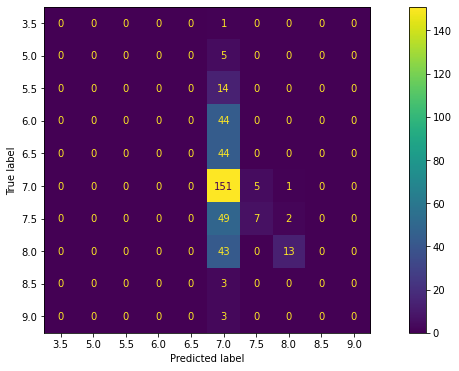

In [46]:
y_pred = pd.DataFrame(tpot.predict(X_test_minmax_scaled))
eval_all(y_test, y_pred.astype(float), 'TPOT TEST')

## Temporal Model 8

### ARIMA

In [ ]:
y = train_test_dict['AS14.01']['train']

# Maps each participant to a fitted model
model_dict = {}
for participant in participants:
    train = train_test_dict[participant]['train']
    
    model = pm.auto_arima(train, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=5, max_q=5, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality (Might have to check for this shit?)
                          start_P=0, 
                          D=0, 
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    model_dict[participant] = model

for participant in sorted(model_dict.keys()):
    model = model_dict[participant]
    print(f"{participant}\t\tAIC: {np.round(model.aic(), 2):.2f}\tBIC: {np.round(model.bic(), 2):.2f}\tParameters: {model.order}")

### Prophet

In [47]:
train = pd.read_csv('data/train.csv', index_col=0)
test = pd.read_csv('data/test.csv', index_col=0)


y_pred = pd.DataFrame()
for idx in train['id'].unique():
    train_current = train[train['id'] == idx][['time', 'next_mood']].rename(columns={'time': 'ds', 'next_mood': 'y'})
    test_current = test[test['id'] == idx][['time', 'next_mood']].rename(columns={'time': 'ds', 'next_mood': 'y'})

    m = Prophet(interval_width=0.95, weekly_seasonality=True);
    model = m.fit(train_current);

    if len(test_current['ds']) > 0:
        forecast = m.predict(pd.DataFrame(test_current['ds']));
        y_pred = pd.concat([y_pred, forecast['yhat']])
    

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_se

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00         0
         4.5       0.00      0.00      0.00         0
         5.0       0.20      0.20      0.20         5
         5.5       0.00      0.00      0.00        14
         6.0       0.26      0.16      0.20        44
         6.5       0.14      0.27      0.19        44
         7.0       0.48      0.36      0.41       157
         7.5       0.23      0.40      0.29        58
         8.0       0.36      0.18      0.24        56
         8.5       0.00      0.00      0.00         3
         9.0       0.00      0.00      0.00         3

    accuracy                           0.28       385
   macro avg       0.14      0.13      0.13       385
weighted avg       0.33      0.28      0.29       385



{'Prophet': {'f1': 0.28, 'rounded_rmse': 0.84, 'rmse': 0.82}}

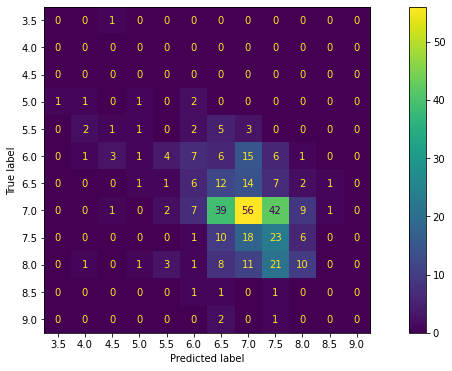

In [48]:
eval_all(y_test, y_pred, 'Prophet')

In [49]:
y_pred.reset_index(drop=True, inplace=True)

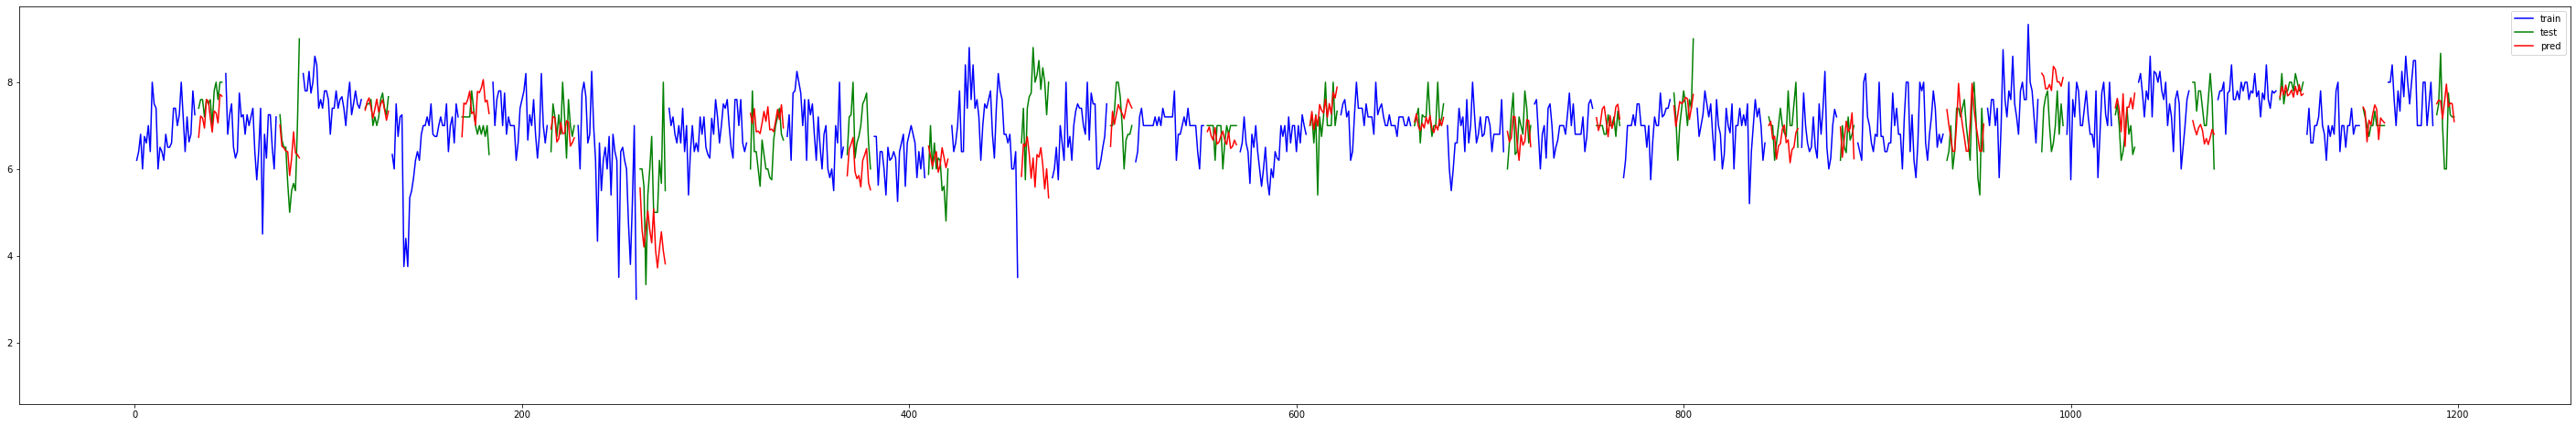

In [50]:
current_series_y = []
current_series_index = []
fig,ax = plt.subplots(figsize=(50,8))

i_prev = y_train.reset_index().iloc[0,:]['index']
for _,row in y_train.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='b')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row['0'])
        current_series_index.append(row['index'])
    i_prev = row['index']

current_series_y = []
current_series_index = []
i_prev = y_test.reset_index().iloc[0,:]['index']
for _,row in y_test.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='g')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row['0'])
        current_series_index.append(row['index'])
    i_prev = row['index']

current_series_y = []
current_series_index = []
y_pred_rescaled = pd.concat([pd.DataFrame(y_test.index, columns=['index']), y_pred], axis=1).set_index('index')
i_prev = y_pred_rescaled.reset_index().iloc[0,:]['index']
for _,row in y_pred_rescaled.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='r')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row[0])
        current_series_index.append(row['index'])
    i_prev = row['index']

l_train, = plt.plot([1], c='b')
l_test, = plt.plot([1], c='g')
l_pred, = plt.plot([1], c='r')



plt.legend([l_train, l_test, l_pred],['train', 'test', 'pred']);

